In [1]:
import eeg_decoder
import numpy as np
from collections import OrderedDict
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%load_ext autoreload
%autoreload 2

In [58]:
experiment_name = 'C01'
data_dir = f'./{experiment_name}'
exp = eeg_decoder.Experiment(experiment_name,data_dir,dev=False,trim_timepoints=[-200,1000])

In [67]:
exp.behavior_files = sorted(list(exp.data_dir.glob('*behavior.csv')))

In [69]:
exp.xdata_files = np.delete(exp.xdata_files,9)
exp.ydata_files =  np.delete(exp.ydata_files,9)
exp.info_files = np.delete(exp.info_files, 9)
exp.behavior_files = np.delete(exp.behavior_files, 9)
exp.nsub = len(exp.xdata_files)

In [373]:
time_window = 50
time_step = 25
trial_bin_size = 15 
n_splits = 30
group_dict = OrderedDict([('1',[11]),('1 (hashtag)',[12]),('1 (letter)',[13]),('1 (flip)',[14]),('Set size 2',[20])])
train_labels = ['1','Set size 2']
wrangl = eeg_decoder.Wrangler(exp.info['times'],time_window,time_step,trial_bin_size,n_splits,group_dict,train_labels=train_labels)
clfr = eeg_decoder.Classification(wrangl,exp.nsub)

In [374]:
def bin_trials_within_block(xdata,ydata,block):

    block_idx = []
    for i,b in enumerate(np.unique(block)):

        x,y = xdata[block == b], ydata[block == b]
        xb, yb = wrangl.bin_trials(x,y,permute_trials=True)
        if i == 0:
            x_concat, y_concat = xb, yb
        else:
            x_concat, y_concat = np.concatenate([x_concat,xb],0), np.concatenate([y_concat, yb],0)
        block_idx.append([int(b)]*len(yb))

    block_idx = np.concatenate(block_idx)
    block_idx = block_idx.astype(int)
    return x_concat,y_concat,block_idx

In [375]:
def get_blocks(ydata):
    block_change = np.diff(ydata)>=1
    # add extra false to beginning
    block_change = np.concatenate([[False],block_change])
    b = 0
    block_count = []
    for i in block_change:
        if i == 1:
            b += 1
        block_count.append(int(b))
    return block_count
    

In [376]:
clfr.confidence_scores = np.empty((exp.nsub,len(wrangl.t),wrangl.n_splits,wrangl.num_labels,26))*np.nan

for isub in range(exp.nsub):

    print(isub)
    xdata,ydata = exp.load_eeg(isub)
    xdata,ydata = wrangl.group_labels(xdata,ydata)
    block = get_blocks(ydata)

    for wrangl.ifold in range(wrangl.n_splits):

        xdata_binned,ydata_binned,block_idx = bin_trials_within_block(xdata,ydata,block)
        X_train_idx, X_test_idx, y_train, y_test = train_test_split(np.arange(len(ydata_binned)),ydata_binned,stratify=ydata_binned)
        
        X_train_all, X_test_all = xdata_binned[X_train_idx], xdata_binned[X_test_idx]
        test_blocks = block_idx[X_test_idx]

        X_train_all, y_train = wrangl.select_training_data(X_train_all, y_train) 
        X_train_all, y_train = wrangl.balance_labels(X_train_all, y_train)
        y_test_shuffle = np.random.permutation(y_test)

        for X_train, X_test in wrangl.roll_over_time(X_train_all, X_test_all):

            X_train, X_test = clfr.standardize(X_train, X_test)

            clfr.classifier.fit(X_train, y_train)

            clfr.acc[isub, wrangl.itime, wrangl.ifold] = clfr.classifier.score(X_test, y_test)
            clfr.acc_shuff[isub, wrangl.itime, wrangl.ifold] = clfr.classifier.score(
                X_test, y_test_shuffle)

            confidence_scores = clfr.classifier.decision_function(X_test)

            df = pd.DataFrame(confidence_scores,columns=['conf'])
            df['condition'] = y_test
            df['block'] = test_blocks
            df['fold'] = wrangl.ifold
            df['time'] = wrangl.itime
            df['sub'] = isub

            if (isub == 0) & (wrangl.ifold == 0) & (wrangl.itime == 0):
                clfdf = df
            else:
                clfdf = pd.concat([clfdf,df])

            for i,ss in enumerate(set(y_test)):
                for ib in set(test_blocks):
                    cs= confidence_scores[(test_blocks==ib)&(y_test==ss)]
                    if len(cs) == 0:
                        cs_mean = np.nan
                    else:
                        cs_mean = np.mean(cs)
                    clfr.confidence_scores[isub,wrangl.itime,wrangl.ifold,i,ib] = cs_mean

0
1
2
3
4
5
6


d:\Cannonball\analysis\eeg_decoder.py:567: RuntimeWarning: divide by zero encountered in longlong_scalars
  label_bins = np.tile(np.arange(n_bins[ilabel]),n_trials[ilabel]//n_bins[ilabel])
d:\Cannonball\analysis\eeg_decoder.py:567: RuntimeWarning: divide by zero encountered in longlong_scalars
  label_bins = np.tile(np.arange(n_bins[ilabel]),n_trials[ilabel]//n_bins[ilabel])
d:\Cannonball\analysis\eeg_decoder.py:567: RuntimeWarning: divide by zero encountered in longlong_scalars
  label_bins = np.tile(np.arange(n_bins[ilabel]),n_trials[ilabel]//n_bins[ilabel])
d:\Cannonball\analysis\eeg_decoder.py:567: RuntimeWarning: divide by zero encountered in longlong_scalars
  label_bins = np.tile(np.arange(n_bins[ilabel]),n_trials[ilabel]//n_bins[ilabel])
d:\Cannonball\analysis\eeg_decoder.py:567: RuntimeWarning: divide by zero encountered in longlong_scalars
  label_bins = np.tile(np.arange(n_bins[ilabel]),n_trials[ilabel]//n_bins[ilabel])
d:\Cannonball\analysis\eeg_decoder.py:567: RuntimeWarni

7
8
9
10
11
12
13
14
15
16
17


d:\Cannonball\analysis\eeg_decoder.py:567: RuntimeWarning: divide by zero encountered in longlong_scalars
  label_bins = np.tile(np.arange(n_bins[ilabel]),n_trials[ilabel]//n_bins[ilabel])
d:\Cannonball\analysis\eeg_decoder.py:567: RuntimeWarning: divide by zero encountered in longlong_scalars
  label_bins = np.tile(np.arange(n_bins[ilabel]),n_trials[ilabel]//n_bins[ilabel])
d:\Cannonball\analysis\eeg_decoder.py:567: RuntimeWarning: divide by zero encountered in longlong_scalars
  label_bins = np.tile(np.arange(n_bins[ilabel]),n_trials[ilabel]//n_bins[ilabel])
d:\Cannonball\analysis\eeg_decoder.py:567: RuntimeWarning: divide by zero encountered in longlong_scalars
  label_bins = np.tile(np.arange(n_bins[ilabel]),n_trials[ilabel]//n_bins[ilabel])
d:\Cannonball\analysis\eeg_decoder.py:567: RuntimeWarning: divide by zero encountered in longlong_scalars
  label_bins = np.tile(np.arange(n_bins[ilabel]),n_trials[ilabel]//n_bins[ilabel])
d:\Cannonball\analysis\eeg_decoder.py:567: RuntimeWarni

In [381]:
c = clfdf.query('condition==1').groupby(['sub','block','time']).mean().reset_index()

In [382]:
for isub in c['sub'].unique():
    sub_df = c.query(f'sub=={isub}').copy()
    
    remap_block = dict(list(enumerate(sub_df.block.unique())))
    remap_block = dict((v,k) for k,v in remap_block.items())
    sub_df['block_num'] = sub_df['block'].map(remap_block)
    if isub ==0:
        df = sub_df
    else:
        df = pd.concat([df,sub_df])

In [385]:
df['block_half'] = (df.block_num>4).astype(int)

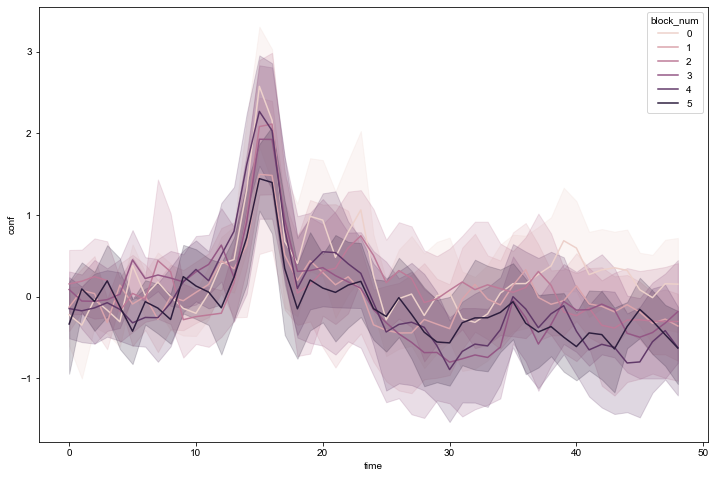

In [389]:
plt.subplots(figsize=(12,8))
sns.lineplot(x='time',y='conf',hue='block_num',data=df.query('block_num<6'))

In [209]:
np.all(np.isnan(conf),0)

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False])

In [163]:
wrangl.labels

['1', '1 (hashtag)', '1 (letter)', '1 (flip)', 'Set size 2']

In [365]:
interp = eeg_decoder.Interpreter(clfr)
# interp.save_results()

In [366]:
interp.confidence_scores = np.nanmean(clfr.confidence_scores,-1)

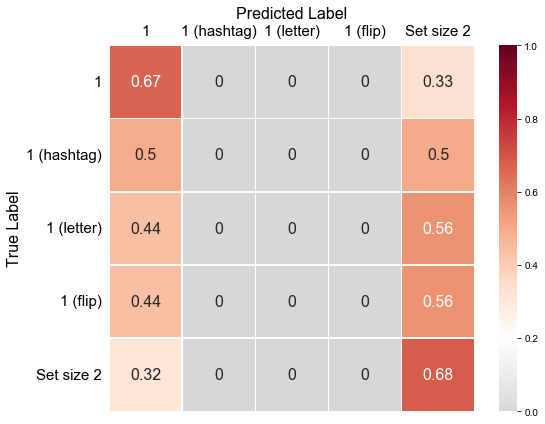

In [98]:
plt.subplots(figsize=(8,6))
interp.plot_confusion_matrix()

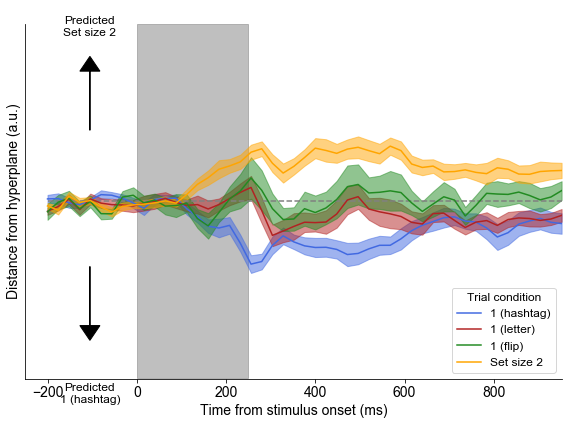

In [367]:
plt.subplots(figsize=(8,6))
interp.plot_hyperplane(ylim=[-3,3],stim_label_xy=[130,3.1])

In [101]:
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline
import pandas as pd
means = np.mean(np.mean(interp.confidence_scores,2)[:,(interp.t<1000)&(interp.t>250)],1)


In [102]:
df = pd.DataFrame(means,columns=interp.labels)

<module 'matplotlib.pyplot' from 'c:\\Users\\William\\Anaconda3\\envs\\archery\\lib\\site-packages\\matplotlib\\pyplot.py'>

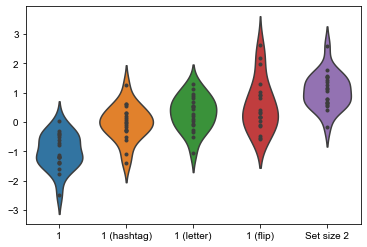

In [103]:
sns.violinplot(data=df,inner='points')
plt

In [104]:
import scipy.stats as sista

In [105]:
sista.ttest_rel(df['1 (hashtag)'],df['1 (letter)'])

Ttest_relResult(statistic=-2.5063659150117266, pvalue=0.021450492814633654)

In [106]:
sista.ttest_rel(df['1 (flip)'],df['1 (letter)'])

Ttest_relResult(statistic=1.4828459252174933, pvalue=0.1545132659406723)